In [1]:
import pandas as pd
import glob
from IPython.display import display, Markdown, Latex, HTML, clear_output
from lxml import objectify
import numpy as np
import seaborn as sns

from nilearn import plotting, image, masking
from nilearn.image import load_img, math_img

In [2]:
%load_ext rpy2.ipython

# LME

In [57]:
df = pd.read_csv('../LLLT-mixed_linear_effects.csv')

In [58]:
# drop last 4 columns
df = df.iloc[:,:-4]

# rename for consistency
df = df.rename({'task_difficulty_pre': 'task_difficultyPre', 'task_difficulty_post': 'task_difficultyPost'}, axis=1)

In [59]:
df

,sid,mci_status,tx_allocation,age,sex,education,task_difficultyPre,task_difficultyPost,LowBackCorrectPre,MidBackCorrectPre,HiBackCorrectPre,LowBackRTPre,MidBackRTPre,HiBackRTPre,LowBackCorrectPost,MidBackCorrectPost,HiBackCorrectPost,LowBackRTPost,MidBackRTPost,HiBackRTPost
0,2006,0,0,73.847,1,14.0,1.0,0.0,41.67,38.10,24.36,1398.01,1275.70,1512.73,38.89,36.90,32.05,1341.18,1166.58,1429.63
1,2007,0,1,70.620,0,16.0,0.0,0.0,44.44,46.43,33.33,790.33,806.11,864.13,41.67,47.62,34.62,991.72,993.08,1032.85
2,2008,0,0,72.036,1,22.0,0.0,0.0,16.67,17.86,16.67,874.25,824.02,764.00,38.89,34.52,35.90,1011.14,1193.67,878.32
3,2009,0,1,72.135,1,16.0,0.0,0.0,48.61,29.76,37.18,703.66,808.82,628.61,47.22,35.71,41.03,555.56,533.06,513.77
4,2010,0,1,73.458,1,14.0,1.0,0.0,31.94,35.71,16.67,642.60,1401.92,1595.57,41.67,46.43,34.62,1062.95,1243.14,1196.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,9109,1,1,62.682,1,18.0,1.0,1.0,100.00,51.19,64.10,1096.86,1787.01,1520.47,97.22,45.24,58.97,1080.23,1478.85,1417.34
86,9110,1,1,61.184,1,22.0,1.0,1.0,98.61,100.00,76.92,596.39,747.64,1239.28,100.00,100.00,73.08,625.31,768.98,1399.75
87,9112,1,0,56.987,1,14.0,1.0,1.0,100.00,90.48,78.21,615.32,683.91,759.14,100.00,90.48,88.46,545.81,603.70,735.73
88,9113,1,1,67.365,1,22.0,1.0,1.0,88.89,76.19,46.15,1032.07,1640.89,1697.02,95.83,80.95,69.23,1295.31,1763.37,1856.11


In [60]:
# reshape to long

df_long = pd.wide_to_long(df,
                i = ['sid', 'mci_status', 'tx_allocation', 'age', 'sex', 'education'],
                stubnames=[ 'task_difficulty', 'LowBackCorrect', 'MidBackCorrect', 'HiBackCorrect', 'LowBackRT', 'MidBackRT', 'HiBackRT'],
                sep='', suffix='\w+',
                j = 'time' )
df_long

task_difficulty  \
sid  mci_status tx_allocation age    sex education time                    
2006 0          0             73.847 1   14.0      Pre               1.0   
                                                   Post              0.0   
2007 0          1             70.620 0   16.0      Pre               0.0   
                                                   Post              0.0   
2008 0          0             72.036 1   22.0      Pre               0.0   
...                                                                  ...   
9112 1          0             56.987 1   14.0      Post              1.0   
9113 1          1             67.365 1   22.0      Pre               1.0   
                                                   Post              1.0   
9116 1          1             66.039 1   NaN       Pre               0.0   
                                                   Post              0.0   

                                                         LowBackCorrect  \
sid  mci_status tx_allocation age    sex education time                   
2006 0          0             73.847 1   14.0      Pre            41.67   
                                                   Post           38.89   
2007 0          1             70.620 0   16.0      Pre            44.44   
                                                   Post           41.67   
2008 0          0             72.036 1   22.0      Pre            16.67   
...                                                                 ...   
9112 1          0             56.987 1   14.0      Post          100.00   
9113 1          1             67.365 1   22.0      Pre            88.89   
                                                   Post           95.83   
9116 1          1             66.039 1   NaN       Pre            34.72   
                                                   Post           43.06   

                                                         MidBackCorrect  \
sid  mci_status tx_allocation age    sex education time                   
2006 0          0             73.847 1   14.0      Pre            38.10   
                                                   Post           36.90   
2007 0          1             70.620 0   16.0      Pre            46.43   
                                                   Post           47.62   
2008 0          0             72.036 1   22.0      Pre            17.86   
...                                                                 ...   
9112 1          0             56.987 1   14.0      Post           90.48   
9113 1          1             67.365 1   22.0      Pre            76.19   
                                                   Post           80.95   
9116 1          1             66.039 1   NaN       Pre            33.33   
                                                   Post           48.81   

                                                         HiBackCorrect  \
sid  mci_status tx_allocation age    sex education time                  
2006 0          0             73.847 1   14.0      Pre           24.36   
                                                   Post          32.05   
2007 0          1             70.620 0   16.0      Pre           33.33   
                                                   Post          34.62   
2008 0          0             72.036 1   22.0      Pre           16.67   
...                                                                ...   
9112 1          0             56.987 1   14.0      Post          88.46   
9113 1          1             67.365 1   22.0      Pre           46.15   
                                                   Post          69.23   
9116 1          1             66.039 1   NaN       Pre           25.64   
                                                   Post          33.33   

                                                         LowBackRT  MidBackRT  \
sid  mci_status tx_allocation age    sex education time                 

In [61]:
df_long.reset_index(inplace=True)  
df_long

,sid,mci_status,tx_allocation,age,sex,education,time,task_difficulty,LowBackCorrect,MidBackCorrect,HiBackCorrect,LowBackRT,MidBackRT,HiBackRT
0,2006,0,0,73.847,1,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73
1,2006,0,0,73.847,1,14.0,Post,0.0,38.89,36.90,32.05,1341.18,1166.58,1429.63
2,2007,0,1,70.620,0,16.0,Pre,0.0,44.44,46.43,33.33,790.33,806.11,864.13
3,2007,0,1,70.620,0,16.0,Post,0.0,41.67,47.62,34.62,991.72,993.08,1032.85
4,2008,0,0,72.036,1,22.0,Pre,0.0,16.67,17.86,16.67,874.25,824.02,764.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,9112,1,0,56.987,1,14.0,Post,1.0,100.00,90.48,88.46,545.81,603.70,735.73
176,9113,1,1,67.365,1,22.0,Pre,1.0,88.89,76.19,46.15,1032.07,1640.89,1697.02
177,9113,1,1,67.365,1,22.0,Post,1.0,95.83,80.95,69.23,1295.31,1763.37,1856.11
178,9116,1,1,66.039,1,NaN,Pre,0.0,34.72,33.33,25.64,700.28,773.42,690.42


In [62]:
df_long.sid = df_long.sid.apply(str)

In [63]:
# change coding
df_long.tx_allocation = df_long.tx_allocation.map({0: 'Control', 1: 'Treatment'})
df_long.sex = df_long.sex.map({0: 'M', 1: 'F'})
df_long.mci_status = df_long.mci_status.map({0: 'MCI', 1: 'HC'})

In [46]:
df_long.to_csv('../LLLT-mixed_linear_effects_long.csv', index = False)
df_long

,sid,mci_status,tx_allocation,age,sex,education,time,task_difficulty,LowBackCorrect,MidBackCorrect,HiBackCorrect,LowBackRT,MidBackRT,HiBackRT
0,2006,MCI,Control,73.847,F,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73
1,2006,MCI,Control,73.847,F,14.0,Post,0.0,38.89,36.90,32.05,1341.18,1166.58,1429.63
2,2007,MCI,Treatment,70.620,M,16.0,Pre,0.0,44.44,46.43,33.33,790.33,806.11,864.13
3,2007,MCI,Treatment,70.620,M,16.0,Post,0.0,41.67,47.62,34.62,991.72,993.08,1032.85
4,2008,MCI,Control,72.036,F,22.0,Pre,0.0,16.67,17.86,16.67,874.25,824.02,764.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,9112,HC,Control,56.987,F,14.0,Post,1.0,100.00,90.48,88.46,545.81,603.70,735.73
176,9113,HC,Treatment,67.365,F,22.0,Pre,1.0,88.89,76.19,46.15,1032.07,1640.89,1697.02
177,9113,HC,Treatment,67.365,F,22.0,Post,1.0,95.83,80.95,69.23,1295.31,1763.37,1856.11
178,9116,HC,Treatment,66.039,F,NaN,Pre,0.0,34.72,33.33,25.64,700.28,773.42,690.42


In [51]:
# get input ppi data

ppi_list = sorted(glob.glob('/scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/level2/*/cope*.nii.gz'))


In [53]:
# make df with sub, ses, and path to ppi file
li = []
for i in ppi_list:
    sub=i.split('/')[9].split('_')[1].split('-')[1]
    ses=i.split('/')[9].split('_')[2].split('-')[1].split('.')[0]
    
    li.append([sub, ses, i])
    
df_ppi = pd.DataFrame(li, columns = ['sid', 'time', 'InputFile']) 

In [54]:
# rename time column values
df_ppi.time = df_ppi.time.map({'A': 'Pre', 'B': 'Post'})

In [55]:
df_ppi

,sid,time,InputFile
0,2003,Pre,/scratch/05201/bhickson/preprocdata/ppi/connec...
1,2006,Pre,/scratch/05201/bhickson/preprocdata/ppi/connec...
2,2007,Pre,/scratch/05201/bhickson/preprocdata/ppi/connec...
3,2009,Pre,/scratch/05201/bhickson/preprocdata/ppi/connec...
4,2010,Pre,/scratch/05201/bhickson/preprocdata/ppi/connec...
...,...,...,...
153,9105,Post,/scratch/05201/bhickson/preprocdata/ppi/connec...
154,9107,Post,/scratch/05201/bhickson/preprocdata/ppi/connec...
155,9109,Post,/scratch/05201/bhickson/preprocdata/ppi/connec...
156,9110,Post,/scratch/05201/bhickson/preprocdata/ppi/connec...


In [83]:
df_ppi.dtypes

sid          object
time         object
InputFile    object
dtype: object

In [64]:
# merge ppi df with behavioral df
df_lme = df_long.merge(df_ppi, on = ['sid', 'time'])
df_lme

,sid,mci_status,tx_allocation,age,sex,education,time,task_difficulty,LowBackCorrect,MidBackCorrect,HiBackCorrect,LowBackRT,MidBackRT,HiBackRT,InputFile
0,2006,MCI,Control,73.847,F,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73,/scratch/05201/bhickson/preprocdata/ppi/connec...
1,2006,MCI,Control,73.847,F,14.0,Post,0.0,38.89,36.90,32.05,1341.18,1166.58,1429.63,/scratch/05201/bhickson/preprocdata/ppi/connec...
2,2007,MCI,Treatment,70.620,M,16.0,Pre,0.0,44.44,46.43,33.33,790.33,806.11,864.13,/scratch/05201/bhickson/preprocdata/ppi/connec...
3,2007,MCI,Treatment,70.620,M,16.0,Post,0.0,41.67,47.62,34.62,991.72,993.08,1032.85,/scratch/05201/bhickson/preprocdata/ppi/connec...
4,2009,MCI,Treatment,72.135,F,16.0,Pre,0.0,48.61,29.76,37.18,703.66,808.82,628.61,/scratch/05201/bhickson/preprocdata/ppi/connec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,9110,HC,Treatment,61.184,F,22.0,Post,1.0,100.00,100.00,73.08,625.31,768.98,1399.75,/scratch/05201/bhickson/preprocdata/ppi/connec...
144,9112,HC,Control,56.987,F,14.0,Pre,1.0,100.00,90.48,78.21,615.32,683.91,759.14,/scratch/05201/bhickson/preprocdata/ppi/connec...
145,9113,HC,Treatment,67.365,F,22.0,Pre,1.0,88.89,76.19,46.15,1032.07,1640.89,1697.02,/scratch/05201/bhickson/preprocdata/ppi/connec...
146,9116,HC,Treatment,66.039,F,NaN,Pre,0.0,34.72,33.33,25.64,700.28,773.42,690.42,/scratch/05201/bhickson/preprocdata/ppi/connec...


In [66]:
#write out df for 3dlme
! mkdir -p ./ppi/connected_regions_0005/lme
df_lme[['sid', 'mci_status', 'tx_allocation', 'age', 'sex', 'time', 'InputFile']].to_csv(f'./ppi/connected_regions_0005/lme/table.txt', index=False, sep=' ', header=['Subj', 'mci_group', 'TxGroup', 'Age', 'Sex', 'Time', 'InputFile'])


In [68]:
# create mean image
! rm ./ppi/connected_regions_0005/lme/mean.nii.gz
! singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
    3dMean -prefix ./ppi/connected_regions_0005/lme/mean.nii.gz {' '.join(df_lme['InputFile'].tolist())}

mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
++ 3dMean: AFNI version=AFNI_18.1.24 (Jun  3 2018) [64-bit]


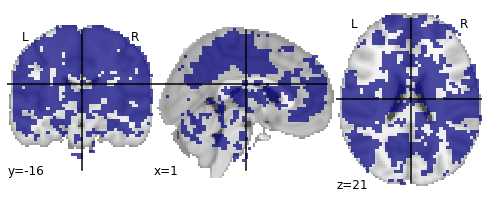

In [70]:
# binarize mean image to use as mask
from nilearn import plotting, image, masking
from nilearn.image import load_img, math_img

mask = math_img('img > 0', img=load_img('./ppi/connected_regions_0005/lme/mean.nii.gz'))
mask.to_filename('./ppi/connected_regions_0005/lme/mask.nii.gz')

plotting.plot_roi(mask)


In [35]:
! singularity exec fcpindi_c-pac_latest-1.5.0.sif 3dresample -master ppi/connected_regions_0005/lme/mask.nii.gz -inset /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask.nii.gz -prefix mni_mask_3mm.nii.gz

** AFNI converts NIFTI_datatype=256 (INT8) in file ppi/connected_regions_0005/lme/mask.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.


# LME: $TxGroup*Time + Age + Sex + Edu$ (Random: $~1 + Subj$)


Within sub factors: Time

Within sub covariate: Age, Edu, RT

Between sub factors: TxGroup

Between sub covariates: mci_status

In [79]:
# Try without mci_status as covariate
 
!module load Rstats; cd ./ppi/connected_regions_0005/lme/; export R_LIBS_USER=/opt/tacc_mounts/home1/06028/tbweng/R/x86_64-pc-linux-gnu-library/3.5:$$R_LIBS_USER; PATH=/scratch/06028/tbweng/afni:$$PATH time R --slave --no-restore --file=/scratch/06028/tbweng/afni/3dLME.R --gui X11 --args \
    -prefix lme_071520.nii.gz -jobs 20 -cio \
    -model "Time*TxGroup+Age+Sex" \
    -qVars "Age" \
    -ranEff "~1" \
    -resid lme-resid_071520.nii.gz \
    -SS_type 3 \
    -num_glt 2 \
    -gltLabel 1 'Time_Control' -gltCode 1 'Time : 1*Post -1*Pre TxGroup : 1*Control' \
    -gltLabel 2 'Time_Treatment' -gltCode 2 'Time : 1*Post -1*Pre TxGroup : 1*Treatment' \
    -num_glf 1 \
    -glfLabel 1 'TxGroup_Time' -glfCode 1 'TxGroup : 1*Control & 1*Treatment Time : 1*Post' \
    -mask mask.nii.gz \
    -dataTable @./table.txt
    


Read 1043 items
** AFNI converts NIFTI_datatype=256 (INT8) in file mask.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
Loading required package: nlme
Package nlme loaded successfully!

Loading required package: phia
Loading required package: car
Loading required package: carData
Package phia loaded successfully!


++++++++++++++++++++++++++++++++++++++++++++++++++++
***** Summary information of data structure *****
82 subjects :  2006 2007 2009 2010 2018 2022 2023 2024 2025 2026 2027 2028 2029 2035 2046 2052 2054 2055 2056 2059 2061 2067 2069 9003 9006 9008 9009 9012 9016 9017 9020 9022 9025 9026 9029 9030 9032 9033 9034 9035 9036 9037 9039 9041 9042 9044 9045 9049 9052 9056 9058 9061 9067 9069 9070 9072 9075 9076 9077 9079 9082 9083 9084 9085 9087 9091 9092 9093 9094 9095 9096 9098 9099 9100 9101 9105 9107 9109 9110 9112 9113 9116 
148 response values
2 levels for factor mci_group : HC 

In [36]:
# Run with MNI template as mask
# Try without mci_status as covariate
 
!module load Rstats; cd ./ppi/connected_regions_0005/lme/; PATH=/scratch/06028/tbweng/afni:$$PATH time R --slave --no-restore --file=/scratch/06028/tbweng/afni/3dLME.R --gui X11 --args \
    -prefix lme_mni_mask.nii.gz -jobs 20 -cio \
    -model "Time*TxGroup+Age+Sex" \
    -qVars "Age" \
    -ranEff "~1" \
    -resid lme_mni_mask-resid.nii.gz \
    -SS_type 3 \
    -num_glt 2 \
    -gltLabel 1 'Time_Control' -gltCode 1 'Time : 1*Post -1*Pre TxGroup : 1*Control' \
    -gltLabel 2 'Time_Treatment' -gltCode 2 'Time : 1*Post -1*Pre TxGroup : 1*Treatment' \
    -num_glf 1 \
    -glfLabel 1 'TxGroup_Time' -glfCode 1 'TxGroup : 1*Control & 1*Treatment Time : 1*Post' \
    -mask /scratch/05201/bhickson/preprocdata/mni_mask_3mm.nii.gz \
    -dataTable @./table.txt

Read 1078 items
Loading required package: nlme
Package nlme loaded successfully!

Loading required package: phia
Loading required package: car
Loading required package: carData
Package phia loaded successfully!


++++++++++++++++++++++++++++++++++++++++++++++++++++
***** Summary information of data structure *****
82 subjects :  2006 2007 2009 2010 2018 2022 2023 2024 2025 2026 2027 2028 2029 2035 2046 2052 2054 2055 2056 2059 2061 2067 2069 9003 9006 9008 9009 9012 9016 9017 9020 9022 9025 9026 9029 9030 9032 9033 9034 9035 9036 9037 9039 9041 9042 9044 9045 9049 9052 9056 9058 9061 9067 9069 9070 9072 9075 9076 9077 9079 9082 9083 9084 9085 9087 9091 9092 9093 9094 9095 9096 9098 9099 9100 9101 9105 9107 9109 9110 9112 9113 9116 
153 response values
2 levels for factor mci_group : HC MCI 
2 levels for factor TxGroup : Control Treatment 
153 centered values for numeric variable Age : 9.796268 9.796268 6.569268 6.569268 8.084268 8.084268 9.407268 9.407268 10.71127 10.71127 16.99627 11.

# cluster thresholding

In [40]:
!OMP_NUM_THREADS=20; cd ./ppi/connected_regions_0005/lme/; \
    singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
        3dFWHMx \
            -acf -detrend \
            -mask ./mask.nii.gz \
            -input ./lme-resid.nii.gz > lme-resid-fwhm.1D

mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
++ 3dFWHMx: AFNI version=AFNI_18.1.24 (Jun  3 2018) [64-bit]
++ Authored by: The Bob
** AFNI converts NIFTI_datatype=256 (INT8) in file ./mask.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Number of voxels in mask = 29776
++ detrending start: 13 baseline funcs, 153 time points
 + detrending done (0.00 CPU s thus far)
++ start ACF calculations out to radius = 18.96 mm
 + ACF done (0.00 CPU s thus far)
++ ACF 1D file [radius ACF mixed_model gaussian_NEWmodel] written to 3dFWHMx.1D
1dplot: error while loading shared libraries: libXm.so.4: cannot open shared object file: No such file or directory
 + and 1dplot-ed to file 3dFWHMx.1D.png


In [44]:
!OMP_NUM_THREADS=20; cd ./ppi/connected_regions_0005/lme/; \
    singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
        3dClustSim \
            -mask mask.nii.gz \
            -acf `tail -n 1 lme-resid-fwhm.1D | tr -s ' ' | cut -d ' ' -f 2,3,4` \
            -niml \
            -prefix lme-cluster

mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
++ 3dClustSim: AFNI version=AFNI_18.1.24 (Jun  3 2018) [64-bit]
++ Authored by: RW Cox and BD Ward
** AFNI converts NIFTI_datatype=256 (INT8) in file mask.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ 29776 voxels in mask (10.96% of total)
++ Kernel function radius = 37.97 mm
++ ACF(0.69,3.41,13.93) => FWHM=9.20 => 61x73x61 pads to 96x120x96
 + Kernel image dimensions 47 x 59 x 47
++ Startup clock time = 0.1 s
++ Using 20 OpenMP threads
Simulating:0123456789.0123456789.0123456789.0123456789.0123456789.!
++ Clock time now = 643.7 s
++ Command fragment to put cluster results into a dataset header;
 + (also echoed to file 3dClustSim.cmd for your scripting pleasure)
 + Append the name of the datasets to be patched to this command:
 3drefit -atrstring AFNI_CLUSTSIM_NN1_1sided file:lme-cluster.NN1_1sided.niml -atrstring AF

In [6]:
p_value = 0.05
cluster_sizes_niml = ''
with open(f'ppi/connected_regions_0005/lme/lme-cluster.NN1_1sided.niml', 'rt') as f:
    cluster_sizes_niml = f.read().replace('3dClustSim_NN1', 'ClustSim')
item = objectify.fromstring(cluster_sizes_niml)

pthr, athr = np.fromstring(item.attrib['pthr'], sep=','), np.fromstring(item.attrib['athr'], sep=',')
cluster_sizes = np.array([np.fromstring(t, sep=' ') for t in item.text.strip('\n').strip().split('\n')])

cluster_size = np.ceil(cluster_sizes[pthr==p_value, athr==0.05][0])

In [7]:
print(cluster_size)

239.0


In [62]:
! singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
    3dinfo -verb ppi/connected_regions_0005/lme/lme.nii.gz

mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
++ 3dinfo: AFNI version=AFNI_18.1.24 (Jun  3 2018) [64-bit]

Dataset File:    ppi/connected_regions_0005/lme/lme.nii.gz
Identifier Code: XYZ_2jbCGAhhJHTBnsdNVOOJiA  Creation Date: Tue Jul  7 16:20:59 2020
Template Space:  ORIG
Dataset Type:    Anat Bucket (-abuc)
Byte Order:      LSB_FIRST {assumed} [this CPU native = LSB_FIRST]
Storage Mode:    NIFTI
Storage Space:   11,951,852 (12 million [mega]) bytes
Geometry String: "MATRIX(3,0,0,-90,0,-3,0,126,0,0,3,-72):61,73,61"
Data Axes Tilt:  Plumb
Data Axes Orientation:
  first  (x) = Right-to-Left
  second (y) = Posterior-to-Anterior
  third  (z) = Inferior-to-Superior   [-orient RPI]
R-to-L extent:   -90.000 [R] -to-    90.000 [L] -step-     3.000 mm [ 61 voxels]
A-to-P extent:   -90.000 [A] -to-   126.000 [P] -step-     3.000 mm [ 73 voxels]
I-to-S extent:   -72.000 [I] -to-   108.000 [S] -step-     3.000 mm [ 61 voxels]
Number of values stored at each pixel = 11
  -- At

In [60]:

for covariate in ['Time_Control', 'Time_Treatment', 'TxGroup_Time']:
    !rm ./ppi/connected_regions_0005/lme/lme-cluster_roi_{covariate}.nii.gz
    !singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
        3dClusterize \
            -inset ./ppi/connected_regions_0005/lme/lme.nii.gz \
            -ithr '{covariate} Z' \
            -mask ./ppi/connected_regions_0005/lme/mask.nii.gz \
            -NN 1 \
            -2sided p={p_value} \
            -clust_nvox {cluster_size} \
            -pref_map ./ppi/connected_regions_0005/lme/lme-cluster_roi_{covariate}.nii.gz

for covariate in ['Age', 'Sex']:
    !rm lme-cluster_roi_{covariate}_F.nii.gz
    !singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
        3dClusterize \
            -inset ./ppi/connected_regions_0005/lme/lme.nii.gz \
            -ithr '{covariate}  F' \
            -mask ./ppi/connected_regions_0005/lme/mask.nii.gz \
            -NN 1 \
            -1sided RIGHT_TAIL p={p_value} \
            -clust_nvox {cluster_size} \
            -pref_map ./ppi/connected_regions_0005/lme/lme-cluster_roi_{covariate}_F.nii.gz

rm: cannot remove './ppi/connected_regions_0005/lme/lme-cluster_roi_Time_Control.nii.gz': No such file or directory
mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
3dClusterize: error while loading shared libraries: libgsl.so.19: cannot open shared object file: No such file or directory
rm: cannot remove './ppi/connected_regions_0005/lme/lme-cluster_roi_Time_Treatment.nii.gz': No such file or directory
mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
3dClusterize: error while loading shared libraries: libgsl.so.19: cannot open shared object file: No such file or directory
rm: cannot remove './ppi/connected_regions_0005/lme/lme-cluster_roi_TxGroup_Time.nii.gz': No such file or directory
mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
3dClusterize: error while loading shared libraries: libgsl.so.19: cannot open shared object file: No such file or directory
rm: cannot remove 'lme-cluster_roi_Age_F.nii.gz': No such file or director

**^could not run 3dClusterize on tacc, ran locally**

## clusterize lme_mni_mask results

In [37]:
!OMP_NUM_THREADS=20; cd ./ppi/connected_regions_0005/lme/; \
    singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
        3dFWHMx \
            -acf -detrend \
            -mask /scratch/05201/bhickson/preprocdata/mni_mask_3mm.nii.gz \
            -input ./lme_mni_mask-resid.nii.gz > lme_mni_mask-resid-fwhm.1D

!OMP_NUM_THREADS=20; cd ./ppi/connected_regions_0005/lme/; \
    singularity exec /scratch/06028/tbweng/cnc_afni_latest.sif \
        3dClustSim \
            -mask /scratch/05201/bhickson/preprocdata/mni_mask_3mm.nii.gz \
            -acf `tail -n 1 lme_mni_mask-resid-fwhm.1D | tr -s ' ' | cut -d ' ' -f 2,3,4` \
            -niml \
            -prefix lme_mni_mask-cluster

p_value = 0.05
cluster_sizes_niml = ''
with open(f'ppi/connected_regions_0005/lme/lme_mni_mask-cluster.NN1_1sided.niml', 'rt') as f:
    cluster_sizes_niml = f.read().replace('3dClustSim_NN1', 'ClustSim')
item = objectify.fromstring(cluster_sizes_niml)

pthr, athr = np.fromstring(item.attrib['pthr'], sep=','), np.fromstring(item.attrib['athr'], sep=',')
cluster_sizes = np.array([np.fromstring(t, sep=' ') for t in item.text.strip('\n').strip().split('\n')])

cluster_size = np.ceil(cluster_sizes[pthr==p_value, athr==0.05][0])
print('cluster size is: ', cluster_size)

mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
++ 3dFWHMx: AFNI version=AFNI_18.1.24 (Jun  3 2018) [64-bit]
++ Authored by: The Bob
++ Number of voxels in mask = 67762
*+ WARNING: removed 14574 voxels from mask because they are constant in time
++ detrending start: 13 baseline funcs, 153 time points
 + detrending done (0.00 CPU s thus far)
++ start ACF calculations out to radius = 19.04 mm
 + ACF done (0.00 CPU s thus far)
** ERROR: (FAILED) attempt to over-write file 3dFWHMx.1D
++ ACF 1D file [radius ACF mixed_model gaussian_NEWmodel] written to 3dFWHMx.1D
1dplot: error while loading shared libraries: libXm.so.4: cannot open shared object file: No such file or directory
 + and 1dplot-ed to file 3dFWHMx.1D.png
mkdir: cannot create directory '/home1/06028/tbweng/R': File exists
++ 3dClustSim: AFNI version=AFNI_18.1.24 (Jun  3 2018) [64-bit]
++ Authored by: RW Cox and BD Ward
++ 67762 voxels in mask (24.95% of total)
++ Kernel function radius = 38.43 mm
++ ACF(0.68,3

NameError: name 'objectify' is not defined

# Plot significant results 

- seed ROI in green 

- cluster-thresholded p < 0.05)

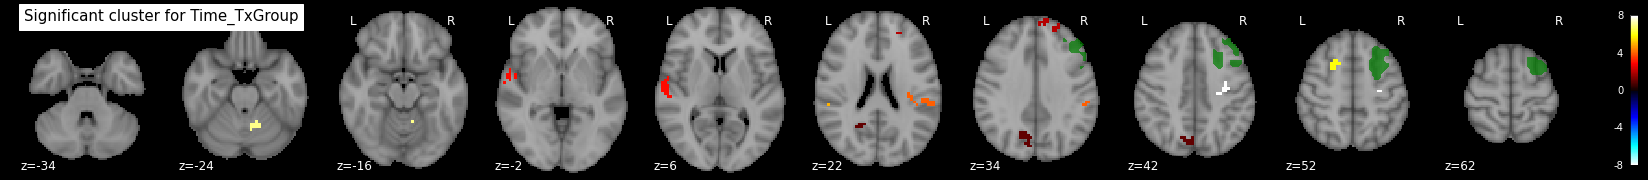

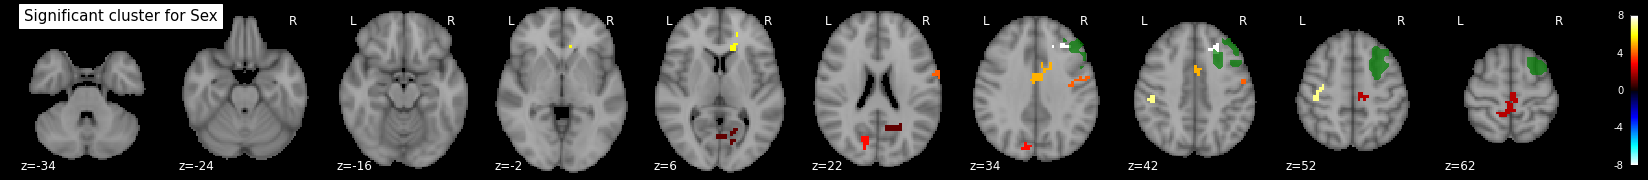

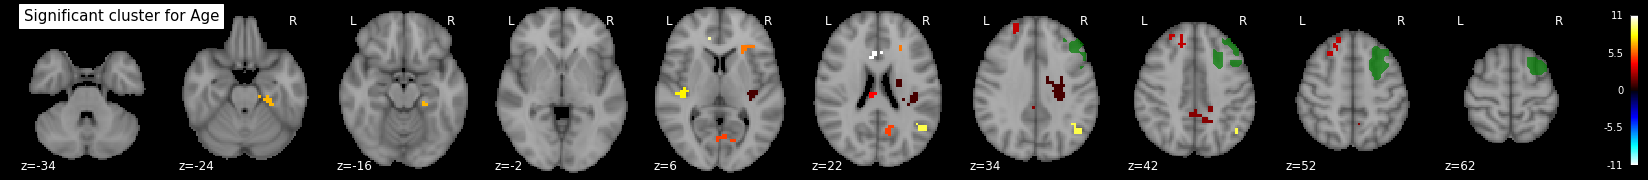

In [88]:
# only ones with significant clusters: Age_F Sex_F Time_TxGroup_F
for i in ['Time_TxGroup', 'Sex', 'Age']:
    display=plotting.plot_stat_map(
            f'./ppi/connected_regions_0005/lme/lme-cluster_roi_{i}_F.nii.gz',
            display_mode="z",
            cut_coords=[-34, -24, -16, -2, 6, 22, 34, 42, 52, 62],
            black_bg=True,
            title=f'Significant cluster for {i}',
            symmetric_cbar=True)
    display.add_contours('connected_regions_0005_bin.nii.gz', colors='g', alpha = .7, levels = [.5], filled = True)



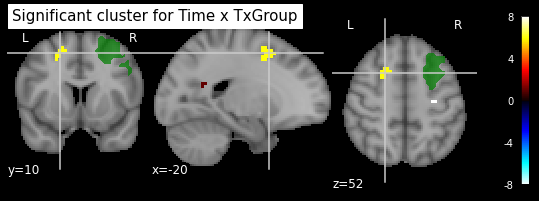

In [85]:
lme_image = './ppi/connected_regions_0005/lme/lme-cluster_roi_Time_TxGroup_F.nii.gz'
display = plotting.plot_stat_map(
            lme_image,
            black_bg=True,
            title=f'Significant cluster for Time x TxGroup',
            cut_coords = [-20, 10, 52],
            symmetric_cbar=True)
display.add_contours('connected_regions_0005_bin.nii.gz', colors='g', alpha = .7, levels = [.5], filled = True)



# Interactive viewer

/home1/06028/tbweng/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



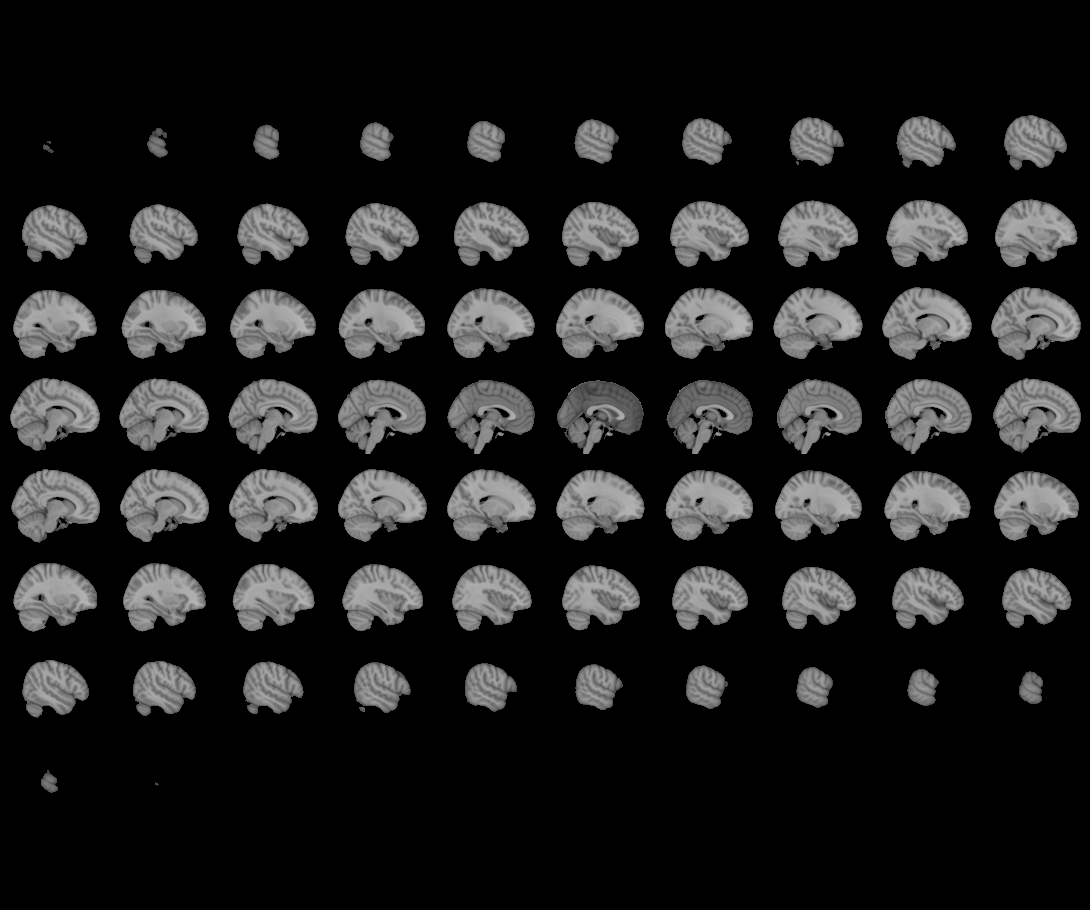
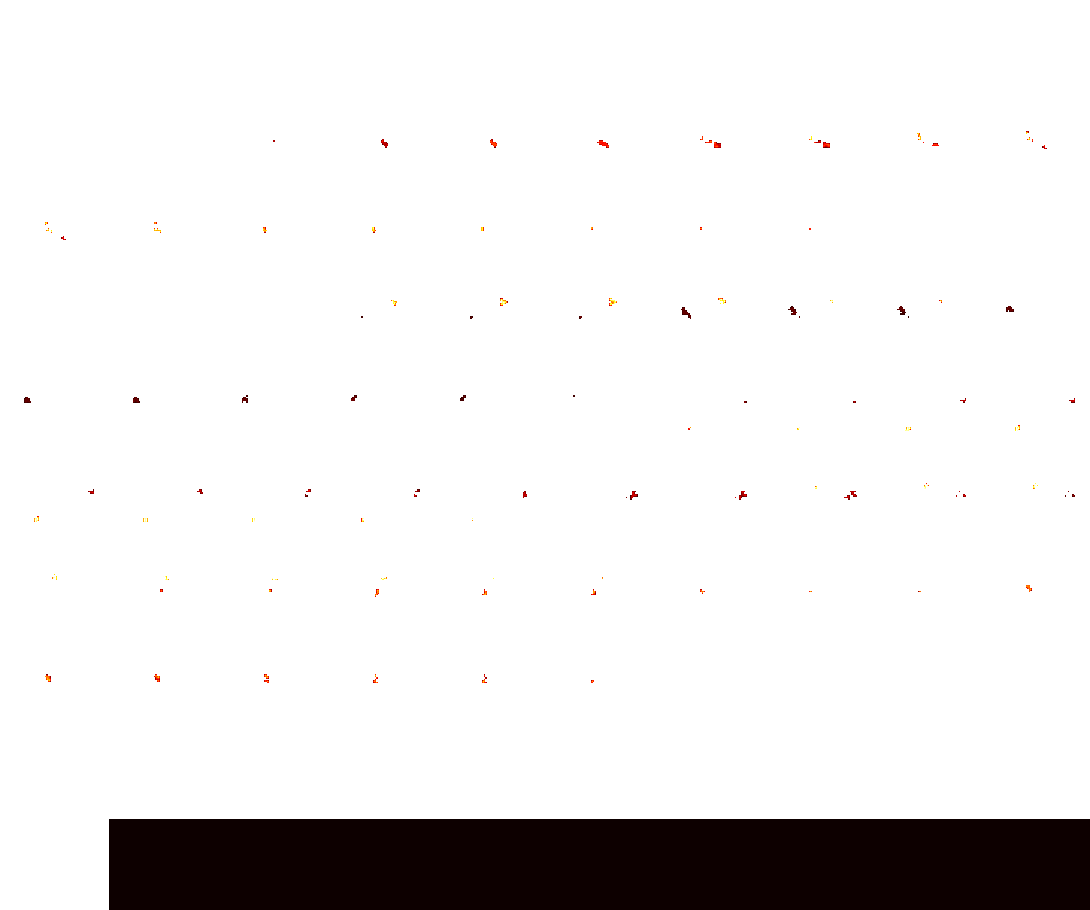

In [3]:
from nilearn.image import threshold_img
from nilearn import plotting

plotting.view_img('./ppi/connected_regions_0005/lme/lme-cluster_roi_Time_TxGroup_F.nii.gz', display_mode='z',
                       title='Time x TxGroup', colorbar=True)

# voxelwise results for BOLD data

In [50]:
sorted(glob.glob('feat_dir/noGSR/run-01/ses-_A_sub*'))[0].split('_')[3].split('-')[1] 

'2003'

In [47]:
# get input ppi data

bold_list = sorted(glob.glob('/scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/level2/*/cope*.nii.gz'))


/scratch/05201/bhickson/preprocdata


In [ ]:

# subject list for renaming level2 cope files
sesA_run1 = [ i.split('_')[3].split('-')[1] for i in sorted(glob.glob('feat_dir/noGSR/run-01/ses-_A_sub*')) ]
sesB_run1 = [ i.split('_')[3].split('-')[1] for i in sorted(glob.glob('feat_dir/noGSR/run-01/ses-_B_sub*')) ]
# write out
with open('ppi/sublist_ses-A.txt', 'w') as f:
    for item in A1:
        f.write("%s\n" % item)
        
with open('ppi/sublist_ses-B.txt', 'w') as f:
    for item in B1:
        f.write("%s\n" % item)
        
# rename second-level files 
for ind, sub in enumerate(sesA_run1):
    !cp /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/level2/A/L2/stats_dir/stats/cope{int(ind) + 1}.nii.gz /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/level2/A/cope_sub-{sub}_ses-A.nii.gz
    
for ind, sub in enumerate(sesB_run1 ):
    !cp /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/level2/A/L2/stats_dir/stats/cope{int(ind) + 1}.nii.gz /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/level2/A/cope_sub-{sub}_ses-B.nii.gz
    

In [ ]:
# Run with MNI template as mask
# Try without mci_status as covariate
 
!module load Rstats; PATH=/scratch/06028/tbweng/afni:$$PATH time R --slave --no-restore --file=/scratch/06028/tbweng/afni/3dLME.R --gui X11 --args \
    -prefix lme_mni_mask.nii.gz -jobs 20 -cio \
    -model "Time*TxGroup+Age+Sex" \
    -qVars "Age" \
    -ranEff "~1" \
    -resid lme_mni_mask-resid.nii.gz \
    -SS_type 3 \
    -num_glt 2 \
    -gltLabel 1 'Time_Control' -gltCode 1 'Time : 1*Post -1*Pre TxGroup : 1*Control' \
    -gltLabel 2 'Time_Treatment' -gltCode 2 'Time : 1*Post -1*Pre TxGroup : 1*Treatment' \
    -num_glf 1 \
    -glfLabel 1 'TxGroup_Time' -glfCode 1 'TxGroup : 1*Control & 1*Treatment Time : 1*Post' \
    -mask /scratch/05201/bhickson/preprocdata/mni_mask_3mm.nii.gz \
    -dataTable @./table.txt

# LME for aggregate (non-voxelwise) data

In [3]:
# load percent signal change into a df
featquery_list = sorted(glob.glob('feat_dir/noGSR/run-0*/ses-_*_sub-*_task-nback/run0.feat/featquery*/report.txt'))

In [7]:
len(featquery_list)

3792

In [8]:
# index column 5 
li = []
for file in featquery_list:

    sub=str(file.split('/')[3].split('_')[2].split('-')[1])
    ses=file.split('/')[3].split('_')[1]
    run=int(file.split('/')[2].split('-')[1])
    roi = file.split('/')[5].split('featquery_')[1]
    
    f = pd.read_csv(file, sep = ' ', header = None)
    psc = 100*f.iat[0,5]
    
    
    li.append([sub, ses, run, psc, roi,])
    
df_featquery = pd.DataFrame(li, columns = ['sid', 'time', 'run', 'psc', 'roi']) 

In [17]:
df_featquery.to_csv('percent_sig_change_long.csv', index = False)

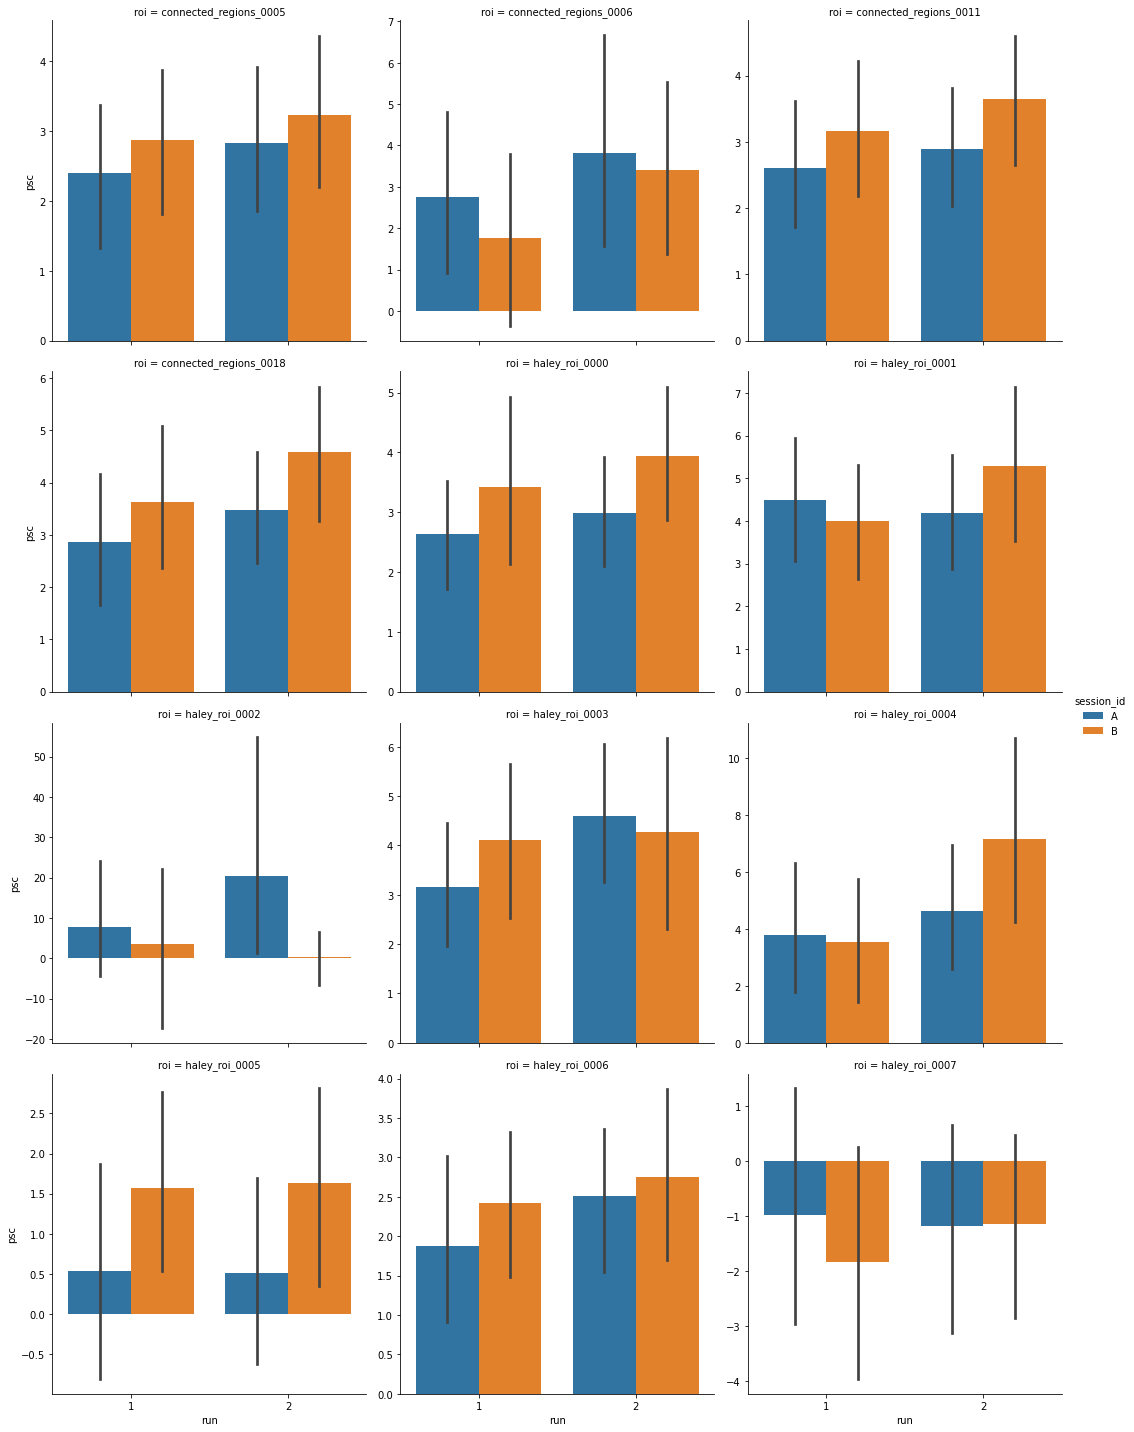

In [10]:
# plot results 
sns.catplot(data=df_featquery, y='psc', hue='time', x='run', col='roi', col_wrap = 3, kind = 'bar', sharey=False)


In [29]:
# rename time column values
df_featquery.time = df_featquery.time.map({'A': 'Pre', 'B': 'Post'})


In [36]:
# make wide to average across runs
df_featquery_wide = df_featquery.loc[df_featquery['run'] == 1].merge(df_featquery.loc[df_featquery['run'] == 2], on = ['sid', 'time', 'roi'])
df_featquery_wide

,sid,time,run_x,psc_x,roi,run_y,psc_y
0,2003,Pre,1,4.6820,connected_regions_0005,2,4.3890
1,2003,Pre,1,10.5000,connected_regions_0006,2,8.7740
2,2003,Pre,1,4.5970,connected_regions_0011,2,4.1610
3,2003,Pre,1,4.1160,connected_regions_0018,2,7.3820
4,2003,Pre,1,2.0600,haley_roi_0000,2,6.2430
...,...,...,...,...,...,...,...
1891,9116,Post,1,6.0500,haley_roi_0003,2,2.7420
1892,9116,Post,1,2.3920,haley_roi_0004,2,17.9100
1893,9116,Post,1,1.5700,haley_roi_0005,2,-6.7250
1894,9116,Post,1,-0.5982,haley_roi_0006,2,-0.7636


In [37]:
df_featquery_wide['psc_avg_across_runs'] = df_featquery_wide[['psc_x', 'psc_y']].mean(axis=1)

In [38]:
df_featquery_wide

,sid,time,run_x,psc_x,roi,run_y,psc_y,psc_avg_across_runs
0,2003,Pre,1,4.6820,connected_regions_0005,2,4.3890,4.53550
1,2003,Pre,1,10.5000,connected_regions_0006,2,8.7740,9.63700
2,2003,Pre,1,4.5970,connected_regions_0011,2,4.1610,4.37900
3,2003,Pre,1,4.1160,connected_regions_0018,2,7.3820,5.74900
4,2003,Pre,1,2.0600,haley_roi_0000,2,6.2430,4.15150
...,...,...,...,...,...,...,...,...
1891,9116,Post,1,6.0500,haley_roi_0003,2,2.7420,4.39600
1892,9116,Post,1,2.3920,haley_roi_0004,2,17.9100,10.15100
1893,9116,Post,1,1.5700,haley_roi_0005,2,-6.7250,-2.57750
1894,9116,Post,1,-0.5982,haley_roi_0006,2,-0.7636,-0.68090


In [39]:
# merge featquery df with behavioral df
df_long = pd.read_csv('../LLLT-mixed_linear_effects_long.csv')
df_long.sid = df_long.sid.apply(str)
df_featquery_lme = df_long.merge(df_featquery_wide, on = ['sid', 'time'])

In [40]:
df_featquery_lme

,sid,mci_status,tx_allocation,age,sex,education,time,task_difficulty,LowBackCorrect,MidBackCorrect,HiBackCorrect,LowBackRT,MidBackRT,HiBackRT,run_x,psc_x,roi,run_y,psc_y,psc_avg_across_runs
0,2006,MCI,Control,73.847,F,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73,1,2.2090,connected_regions_0005,2,2.8540,2.53150
1,2006,MCI,Control,73.847,F,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73,1,-5.1060,connected_regions_0006,2,-1.4370,-3.27150
2,2006,MCI,Control,73.847,F,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73,1,0.0518,connected_regions_0011,2,0.4663,0.25905
3,2006,MCI,Control,73.847,F,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73,1,-4.4460,connected_regions_0018,2,-5.8380,-5.14200
4,2006,MCI,Control,73.847,F,14.0,Pre,1.0,41.67,38.10,24.36,1398.01,1275.70,1512.73,1,1.4450,haley_roi_0000,2,2.3160,1.88050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,9116,HC,Treatment,66.039,F,NaN,Post,0.0,43.06,48.81,33.33,764.66,871.71,693.05,1,6.0500,haley_roi_0003,2,2.7420,4.39600
1772,9116,HC,Treatment,66.039,F,NaN,Post,0.0,43.06,48.81,33.33,764.66,871.71,693.05,1,2.3920,haley_roi_0004,2,17.9100,10.15100
1773,9116,HC,Treatment,66.039,F,NaN,Post,0.0,43.06,48.81,33.33,764.66,871.71,693.05,1,1.5700,haley_roi_0005,2,-6.7250,-2.57750
1774,9116,HC,Treatment,66.039,F,NaN,Post,0.0,43.06,48.81,33.33,764.66,871.71,693.05,1,-0.5982,haley_roi_0006,2,-0.7636,-0.68090


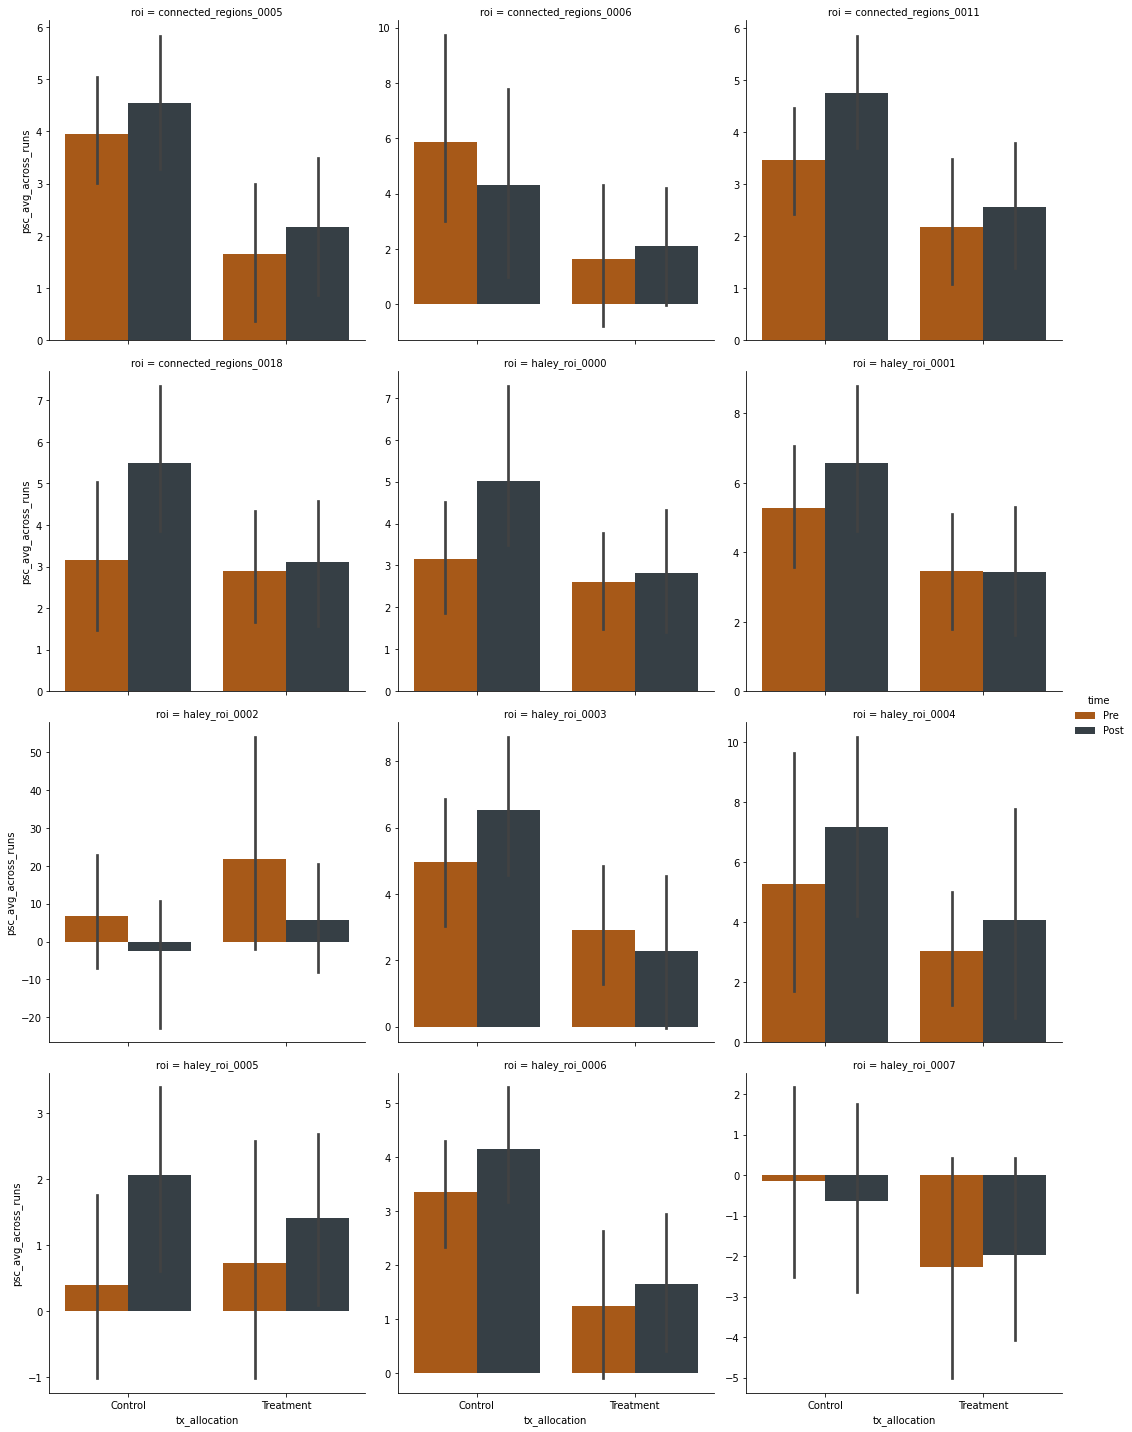

In [46]:
# plot results 
sns.catplot(data=df_featquery_lme, y='psc_avg_across_runs', hue='time', x='tx_allocation', col='roi', col_wrap = 3, kind = 'bar', palette = ['#BF5700', '#333f48'], sharey=False)


In [41]:
%%R -i df_featquery_lme

library(ggplot2)
library(lme4)

#lmer() control: sets errors to warnings, increases iterations (maxfun).  
turn_off <- lmerControl(optimizer="bobyqa", # Nelder_Mead, bobyqa is the default 
  optCtrl = list(maxfun = 2e5), # Increase the number of iterations: helps convergence
  check.nobs.vs.nlev = "warning",
  check.nobs.vs.rankZ = "warning",
  check.nlev.gtreq.5 = "warning", 
  check.nobs.vs.nRE = "warning",
  check.rankX = c("ignore"),
  check.scaleX = "warning",
  check.formula.LHS = "warning",
  check.conv.grad   = .makeCC("warning", tol = 1e-3, relTol = NULL))

options(scipen=999)

In [44]:
%%R
lme_results <- lme4::lmer(psc_avg_across_runs ~ tx_allocation*time + age + sex + (1 | sid),REML = FALSE, data = subset(df_featquery_lme, roi=='connected_regions_0005'), control = turn_off )
summary(lme_results)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: psc_avg_across_runs ~ tx_allocation * time + age + sex + (1 |  
    sid)
   Data: subset(df_featquery_lme, roi == "connected_regions_0005")
Control: turn_off

     AIC      BIC   logLik deviance df.resid 
   797.9    821.9   -391.0    781.9      140 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1000 -0.5045 -0.0047  0.4481  3.2749 

Random effects:
 Groups   Name        Variance Std.Dev.
 sid      (Intercept) 7.047    2.655   
 Residual             6.297    2.509   
Number of obs: 148, groups:  sid, 82

Fixed effects:
                               Estimate Std. Error t value
(Intercept)                     13.9570     2.6971   5.175
tx_allocationTreatment          -2.2307     0.8580  -2.600
timePre                         -0.7135     0.6393  -1.116
age                             -0.1524     0.0407  -3.745
sexM                             0.5373     0.7583   0.709
tx_allocationTreatment:timePre   0.3